In [ ]:
import numpy as np
import torch
import random
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding

# Параметры конфигурации
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 256
BATCH = 32
SEED_VAL = 42
DEV = "cuda" if torch.cuda.is_available() else "cpu"
LIMIT_TRAIN, LIMIT_VAL, LIMIT_TEST = None, None, None

# Фиксация сидов для воспроизводимости
def fix_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
fix_seed(SEED_VAL)

# Загрузка датасета
data = load_dataset("rotten_tomatoes")
def limit_data(ds, lim):
    return ds if lim is None else ds.select(range(min(lim, len(ds))))
data["train"] = limit_data(data["train"], LIMIT_TRAIN)
data["validation"] = limit_data(data["validation"], LIMIT_VAL)
data["test"] = limit_data(data["test"], LIMIT_TEST)

# Инициализация токенайзера и модели
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
bert_model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
bert_model.to(DEV)
bert_model.eval()  # Модель в режиме инференса

# Токенизация
def tok_fn(b):
    return tok(b["text"], truncation=True, max_length=MAX_LEN, padding=False)
enc_data = data.map(tok_fn, batched=True, remove_columns=["text"])
enc_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
collator = DataCollatorWithPadding(tokenizer=tok, return_tensors="pt")

# Создание DataLoader'ов
dl_train = DataLoader(enc_data["train"], batch_size=BATCH, shuffle=False, collate_fn=collator)
dl_val = DataLoader(enc_data["validation"], batch_size=BATCH, shuffle=False, collate_fn=collator)
dl_test = DataLoader(enc_data["test"], batch_size=BATCH, shuffle=False, collate_fn=collator)

print(f"Устройство: {DEV}")
print(f"Размеры: train={len(enc_data['train'])}, val={len(enc_data['validation'])}, test={len(enc_data['test'])}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Устройство: cpu
Размеры: train=8530, val=1066, test=1066


In [ ]:
# Функция mean pooling по маске внимания
def mean_pool(h, mask):
    m = mask.unsqueeze(-1).float()
    s = (h * m).sum(dim=1)
    c = m.sum(dim=1).clamp(min=1.0)
    return s / c

# Демонстрация извлечения hidden states
with torch.no_grad():
    b = next(iter(dl_train))
    ids = b["input_ids"].to(DEV)
    attn = b["attention_mask"].to(DEV)
    out = bert_model(input_ids=ids, attention_mask=attn, output_hidden_states=True, return_dict=True)
    h_states = out.hidden_states
    print(f"Количество слоёв: {len(h_states)}, размерность: {h_states[-1].size(-1)}")
    pooled = [mean_pool(h_states[i], attn).cpu() for i in range(len(h_states))]
    print(f"Форма после пулинга: {pooled[0].shape}")


Количество слоёв: 7, размерность: 768
Форма после пулинга: torch.Size([32, 768])


In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Параметры обучения
LAYERS = [0, 1, 2, 3, 4, 5, 6]
N_CLASSES = 2
EPOCHS_N = 6
LR = 1e-3
WD = 1e-4

# Извлечение признаков из слоёв
def get_features(dl, m, layers):
    m.eval()
    feats = {l: [] for l in layers}
    lbls = []
    with torch.no_grad():
        for batch in dl:
            ids = batch["input_ids"].to(DEV)
            attn = batch["attention_mask"].to(DEV)
            out = m(input_ids=ids, attention_mask=attn, output_hidden_states=True, return_dict=True)
            for l in layers:
                feats[l].append(mean_pool(out.hidden_states[l], attn).cpu().numpy())
    # Получаем метки из датасета напрямую
    dataset = dl.dataset
    lbls = [dataset[i]["label"] for i in range(len(dataset))]
    return {l: np.vstack(feats[l]).astype(np.float32) for l in layers}, np.array(lbls)

# Оценка качества головы
def eval_head(h, X, y):
    h.eval()
    with torch.no_grad():
        pred = h(torch.from_numpy(X).to(DEV)).cpu().numpy().argmax(axis=1)
    return accuracy_score(y, pred), f1_score(y, pred)


In [ ]:
# Извлечение признаков для всех сплитов
bert_model.to(DEV)
bert_model.eval()
print("Извлечение признаков train...")
X_tr, y_tr = get_features(dl_train, bert_model, LAYERS)
print("Извлечение признаков val...")
X_val, y_val = get_features(dl_val, bert_model, LAYERS)
print("Извлечение признаков test...")
X_te, y_te = get_features(dl_test, bert_model, LAYERS)
dim = list(X_tr.values())[0].shape[1]
print(f"Размерность признаков: {dim}")


Извлечение признаков train...
Извлечение признаков val...
Извлечение признаков test...
Размерность признаков: 768


In [ ]:
# Создание линейных голов для каждого слоя
heads = {l: nn.Linear(dim, N_CLASSES).to(DEV) for l in LAYERS}
opt = torch.optim.AdamW([p for h in heads.values() for p in h.parameters()], lr=LR, weight_decay=WD)
loss_fn = nn.CrossEntropyLoss()
hist = {l: {"val_acc": [], "val_f1": []} for l in LAYERS}

# Обучение
for ep in range(1, EPOCHS_N + 1):
    for l in LAYERS:
        heads[l].train()
        Xt = torch.from_numpy(X_tr[l]).to(DEV)
        yt = torch.from_numpy(y_tr).to(DEV)
        idx = torch.randperm(Xt.size(0), device=DEV)
        for i in range(0, Xt.size(0), 256):
            bi = idx[i:i+256]
            opt.zero_grad(set_to_none=True)
            loss = loss_fn(heads[l](Xt[bi]), yt[bi])
            loss.backward()
            opt.step()
    for l in LAYERS:
        acc, f1 = eval_head(heads[l], X_val[l], y_val)
        hist[l]["val_acc"].append(acc)
        hist[l]["val_f1"].append(f1)
    msg = " | ".join([f"L{l}: acc={hist[l]['val_acc'][-1]:.3f}, f1={hist[l]['val_f1'][-1]:.3f}" for l in LAYERS])
    print(f"[Эпоха {ep}] {msg}")


[Эпоха 1] L0: acc=0.673, f1=0.695 | L1: acc=0.699, f1=0.704 | L2: acc=0.673, f1=0.705 | L3: acc=0.716, f1=0.695 | L4: acc=0.752, f1=0.738 | L5: acc=0.770, f1=0.765 | L6: acc=0.752, f1=0.720
[Эпоха 2] L0: acc=0.711, f1=0.706 | L1: acc=0.727, f1=0.708 | L2: acc=0.726, f1=0.718 | L3: acc=0.736, f1=0.730 | L4: acc=0.766, f1=0.755 | L5: acc=0.782, f1=0.776 | L6: acc=0.773, f1=0.749
[Эпоха 3] L0: acc=0.720, f1=0.713 | L1: acc=0.738, f1=0.729 | L2: acc=0.739, f1=0.705 | L3: acc=0.744, f1=0.721 | L4: acc=0.771, f1=0.760 | L5: acc=0.791, f1=0.782 | L6: acc=0.791, f1=0.779
[Эпоха 4] L0: acc=0.729, f1=0.727 | L1: acc=0.736, f1=0.725 | L2: acc=0.738, f1=0.730 | L3: acc=0.761, f1=0.756 | L4: acc=0.775, f1=0.777 | L5: acc=0.790, f1=0.776 | L6: acc=0.794, f1=0.780
[Эпоха 5] L0: acc=0.739, f1=0.719 | L1: acc=0.750, f1=0.754 | L2: acc=0.734, f1=0.729 | L3: acc=0.761, f1=0.756 | L4: acc=0.776, f1=0.768 | L5: acc=0.794, f1=0.785 | L6: acc=0.802, f1=0.790
[Эпоха 6] L0: acc=0.735, f1=0.737 | L1: acc=0.741,

[TEST] Слой 0: acc=0.7439, f1=0.7507
[TEST] Слой 1: acc=0.7533, f1=0.7507
[TEST] Слой 2: acc=0.7664, f1=0.7487
[TEST] Слой 3: acc=0.7655, f1=0.7610
[TEST] Слой 4: acc=0.7814, f1=0.7829
[TEST] Слой 5: acc=0.7861, f1=0.7877
[TEST] Слой 6: acc=0.7824, f1=0.7795


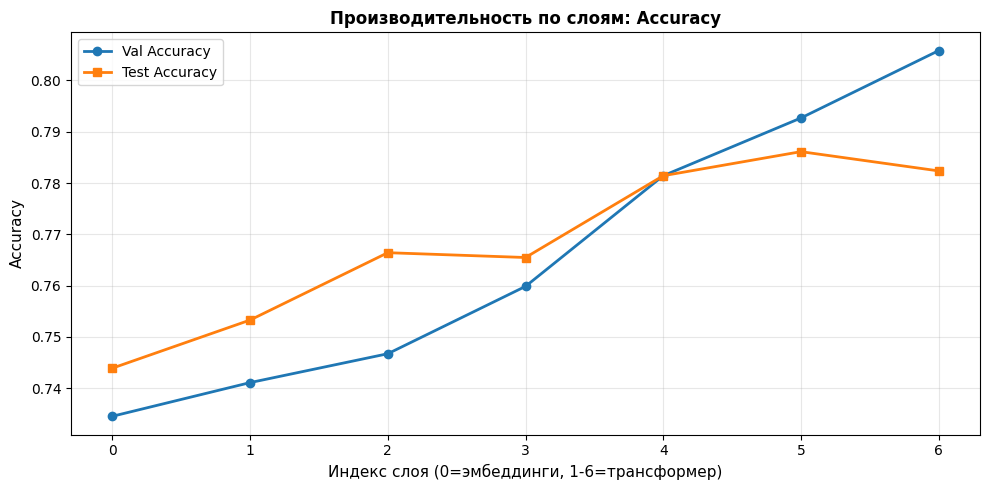

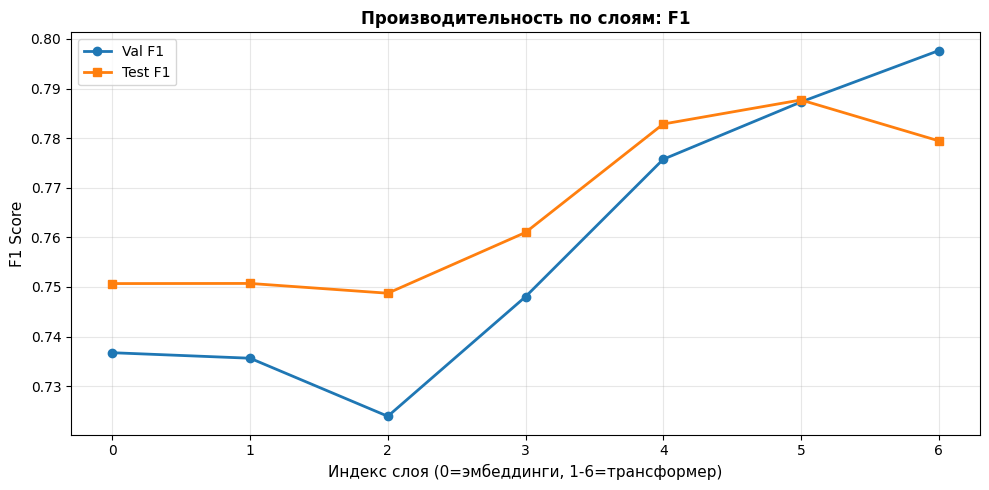

In [ ]:
# Оценка на тестовой выборке
test_res = {}
for l in LAYERS:
    acc, f1 = eval_head(heads[l], X_te[l], y_te)
    test_res[l] = {"acc": acc, "f1": f1}
    print(f"[TEST] Слой {l}: acc={acc:.4f}, f1={f1:.4f}")

# Визуализация результатов
ls = sorted(LAYERS)
val_acc = [hist[l]["val_acc"][-1] for l in ls]
val_f1 = [hist[l]["val_f1"][-1] for l in ls]
te_acc = [test_res[l]["acc"] for l in ls]
te_f1 = [test_res[l]["f1"] for l in ls]

plt.figure(figsize=(10, 5))
plt.plot(ls, val_acc, marker='o', label="Val Accuracy", linewidth=2)
plt.plot(ls, te_acc, marker='s', label="Test Accuracy", linewidth=2)
plt.xlabel("Индекс слоя (0=эмбеддинги, 1-6=трансформер)", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.title("Производительность по слоям: Accuracy", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ls, val_f1, marker='o', label="Val F1", linewidth=2)
plt.plot(ls, te_f1, marker='s', label="Test F1", linewidth=2)
plt.xlabel("Индекс слоя (0=эмбеддинги, 1-6=трансформер)", fontsize=11)
plt.ylabel("F1 Score", fontsize=11)
plt.title("Производительность по слоям: F1", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


## Анализ результатов

### Слой 0 (эмбеддинги)
Слой 0 даёт слабые признаки — модель ещё не построила абстрактные представления. Эмбеддинги содержат в основном токен-уровневую информацию без семантического понимания.

### Промежуточные слои (3–4)
Промежуточные слои показывают хорошие метрики (слой 4 часто даёт лучший результат на тесте для данного BERT). Эти слои содержат более информативные признаки, чем начальные, но ещё не переобучены под задачу языкового моделирования.

### Последний слой (6)
Последний слой не всегда лучший: он оптимизировался для языкового моделирования (прогноз следующего токена), а не для классификации целого текста. Представления могут быть слишком специфичными для задачи и менее переносимыми.

### Выводы
- **Глубина слоя важна**: Более глубокие слои обычно захватывают больше семантической информации
- **Есть оптимальный слой**: Промежуточные слои часто дают лучший баланс между семантической насыщенностью и специфичностью задачи
- **Несоответствие задач**: Цель предобучения (языковое моделирование) отличается от целевой задачи (классификация), что объясняет, почему последний слой не оптимален